In [148]:
PYTHONHASHSEED = 123

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import pickle

In [150]:
seed = 70308

In [151]:
np.random.seed(seed)

In [152]:
data_train = pd.read_csv("./train_val_test/train.csv", index_col = 'Unnamed: 0')

In [153]:
data_train

,Laptop_name,OS,CPU,CPU_Threads,CPU_Boosted_Clock,CPU_L3(MB),CPU_TDP(W),GPU,GPU_Memory(GB),GPU_Memory_Type,GPU memory clock(MHz),RAM(GB),RAM_DDR,Storage(GB),Display_Inch,Display_Height(pixel),Weight(kg),Brand,Price(USD)
637,Lenovo Yoga Slim 7 ProX 14ARH7-82TL000BGE,Windows,ryzen 9,16,4.9,16,35,geforce rtx 3050 mobile,4,GDDR6,1500,32,5,1024,14.5,3072,1.450,Lenovo,1945.0
1657,Gigabyte Aero 15 OLED XC,Windows,core i7,16,5.0,16,45,geforce rtx 3070 mobile,8,GDDR6,1750,32,4,1024,15.6,3840,2.230,Gigabyte Aero,2720.0
1376,Asus TUF Gaming A15 FA506QR-AZ061T,Windows,ryzen 7,16,4.4,16,45,geforce rtx 3070 mobile,8,GDDR6,1750,16,4,1024,15.6,1920,2.300,Asus,2011.0
733,LG Gram 14Z90Q,Windows,core i5,16,4.4,12,28,iris xe graphics g7 80eus,0,NaN,0,16,4,512,14.0,1920,0.980,LG,1156.0
608,Lenovo IdeaPad Flex 5i 14IAU7,Windows,core i5,12,4.4,12,15,iris xe graphics g7 80eus,0,NaN,0,16,4,512,14.0,1920,1.613,Lenovo,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Asus Vivobook Pro 16X M7600QC-L2002T,Windows,ryzen 7,16,4.4,16,45,geforce rtx 3050 mobile,4,GDDR6,1500,16,4,1024,16.0,3840,1.950,Asus,1261.0
1724,"HP EliteBook x360 1040 G7, i7-10810U",Windows,core i7,12,4.9,12,25,uhd graphics 620,0,NaN,0,16,4,512,14.0,1920,1.361,HP,2500.0
1077,LG Gram 16 2-in-1 16T90P,Windows,core i7,8,4.7,12,28,iris xe graphics g7 96eus,0,NaN,0,16,4,512,16.0,2560,1.454,LG,1600.0
33,Acer Swift X SFX14-51G-79RJ,Windows,core i7,16,4.7,18,28,geforce rtx 3050 ti mobile,4,GDDR6,1500,16,5,1024,14.0,2240,1.400,Acer,1366.0


In [154]:
data_train.drop(axis = 1, labels = ['Brand', 'CPU', 'GPU', 'Laptop_name'], inplace = True)

In [155]:
y_train = np.log(data_train['Price(USD)'])
X_train = data_train.drop(axis = 1, labels = 'Price(USD)')

## Data Preparation

In [156]:
cat_attribs = ['GPU_Memory_Type', 'OS', 'RAM_DDR']
num_attribs = list(set(X_train.columns).difference(set(cat_attribs)))
print(num_attribs)

['RAM(GB)', 'CPU_Threads', 'Display_Inch', 'CPU_TDP(W)', 'GPU_Memory(GB)', 'Display_Height(pixel)', 'Weight(kg)', 'CPU_L3(MB)', 'CPU_Boosted_Clock', 'GPU memory clock(MHz)', 'Storage(GB)']


In [157]:
X_train_original = X_train.copy()

### one-hot categorical attributes

In [158]:
oh_encoder = OneHotEncoder()
X_train_cat = oh_encoder.fit_transform(X_train[cat_attribs])
X_train = np.c_[X_train.drop(labels = cat_attribs, axis = 1).values,X_train_cat.toarray()]

In [159]:
oh_encoder.categories_

[array(['GDDR5', 'GDDR6', 'LPDDR4X', nan], dtype=object),
 array(['Linux', 'MacOS', 'Windows'], dtype=object),
 array([1, 3, 4, 5], dtype=int64)]

In [160]:
X_train = pd.DataFrame(X_train, index = data_train.index, 
                          columns = num_attribs + ['GDDR5','GDDR6','LPDDR4X','NoGPU'] + ['Linux', 'MacOS', 'Windows'] + ['DDR1','DDR3','DDR4','DDR5'])

In [161]:
X_train

,RAM(GB),CPU_Threads,Display_Inch,CPU_TDP(W),GPU_Memory(GB),Display_Height(pixel),Weight(kg),CPU_L3(MB),CPU_Boosted_Clock,GPU memory clock(MHz),...,GDDR6,LPDDR4X,NoGPU,Linux,MacOS,Windows,DDR1,DDR3,DDR4,DDR5
637,16.0,4.9,16.0,35.0,4.0,1500.0,32.0,1024.0,14.5,3072.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1657,16.0,5.0,16.0,45.0,8.0,1750.0,32.0,1024.0,15.6,3840.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1376,16.0,4.4,16.0,45.0,8.0,1750.0,16.0,1024.0,15.6,1920.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
733,16.0,4.4,12.0,28.0,0.0,0.0,16.0,512.0,14.0,1920.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
608,12.0,4.4,12.0,15.0,0.0,0.0,16.0,512.0,14.0,1920.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,16.0,4.4,16.0,45.0,4.0,1500.0,16.0,1024.0,16.0,3840.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1724,12.0,4.9,12.0,25.0,0.0,0.0,16.0,512.0,14.0,1920.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1077,8.0,4.7,12.0,28.0,0.0,0.0,16.0,512.0,16.0,2560.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
33,16.0,4.7,18.0,28.0,4.0,1500.0,16.0,1024.0,14.0,2240.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### standardize numerical attributes

In [162]:
std_scaler = StandardScaler()
X_train[num_attribs] = std_scaler.fit_transform(X_train[num_attribs])

## Transformation pipelines

In [163]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
full_pipeline.fit(X_train_original)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['RAM(GB)', 'CPU_Threads', 'Display_Inch',
                                  'CPU_TDP(W)', 'GPU_Memory(GB)',
                                  'Display_Height(pixel)', 'Weight(kg)',
                                  'CPU_L3(MB)', 'CPU_Boosted_Clock',
                                  'GPU memory clock(MHz)', 'Storage(GB)']),
                                ('cat', OneHotEncoder(),
                                 ['GPU_Memory_Type', 'OS', 'RAM_DDR'])])

In [164]:
data_val = pd.read_csv("./train_val_test/test.csv", index_col = 'Unnamed: 0')
data_val.drop(['Year', 'CPU_Default_Clock', 'CPU_Transistor_Size(nm)', 'GPU clock(MHz)',
           'RAM_bus', 'CPU_Cores', 'GPU_Bus_Width(bit)', 'Display_Width(pixel)', 'Brand', 'CPU', 'GPU', 'Laptop_name'],
           axis = 1, inplace = True)
y_val = data_val['Price(USD)']
X_val = data_val.drop('Price(USD)', axis = 1)
X_val_prepared = full_pipeline.transform(X_val)
X_val_prepared = pd.DataFrame(X_val_prepared, index = y_val.index, columns = num_attribs + ['GDDR5','GDDR6','LPDDR4X','NoGPU'] + ['Linux', 'MacOS', 'Windows'] + ['DDR1','DDR3','DDR4','DDR5'])

## Ridge Regression

In [165]:
n = 50
best_alpha = None
best_error = float('inf')
best_estimator = None
rv = reciprocal(0.001, 10)
for alpha in rv.rvs(size = n):
    estimator = Ridge(alpha = alpha)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_alpha = alpha

In [166]:
print("best parameter: ",best_alpha)
print("rmse: ", best_error)

best parameter:  6.180376742169328
rmse:  1072.919445895982


In [167]:
print(pd.concat([X_train, X_val_prepared]))

       RAM(GB)  CPU_Threads  Display_Inch  CPU_TDP(W)  GPU_Memory(GB)  \
637   0.775202     1.009923      0.320551    0.315594        0.284763   
1657  0.775202     1.237929      0.320551    1.173579        1.356371   
1376  0.775202    -0.130107      0.320551    1.173579        1.356371   
733   0.775202    -0.130107     -0.292677   -0.284995       -0.786845   
608  -0.060643    -0.130107     -0.292677   -1.400375       -0.786845   
...        ...          ...           ...         ...             ...   
1399 -0.933467    -0.896487     -1.444908   -1.400375       -0.786845   
1031 -0.933467    -0.896487      0.384308   -0.284995       -0.786845   
661  -0.103719     0.775202      0.384308    0.315594        1.356371   
1654  1.555779     0.775202      0.384308    0.315594        1.356371   
783   4.874773     1.611046      1.736337    1.173579        3.499588   

      Display_Height(pixel)  Weight(kg)  CPU_L3(MB)  CPU_Boosted_Clock  \
637                0.832400    1.555779    0.7814

In [168]:
ridge = Ridge(alpha = best_alpha)
ridge.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

Ridge(alpha=6.180376742169328)

<AxesSubplot: >

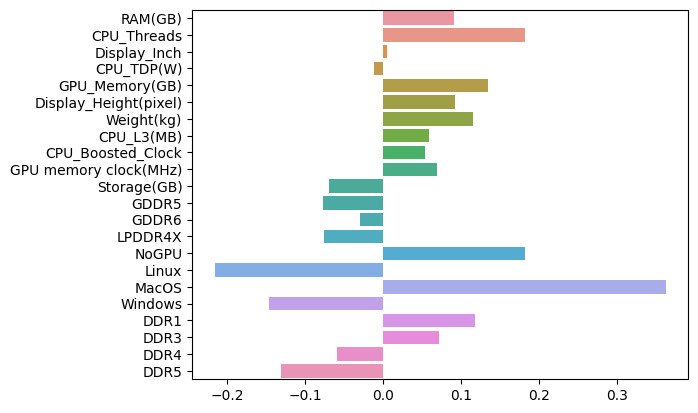

In [169]:
sns.barplot(y = X_train.columns, x = ridge.coef_, orient = 'h')

In [170]:
pickle.dump(ridge, open('ridgemodel.pkl','wb'))

In [171]:
ridgemodel = pickle.load(open('ridgemodel.pkl','rb'))
input1 = [1,1,1,1,1,1,1,1,1,1,1]
input1 = list(std_scaler.transform([input1])[0])
input2 = [1,0,0,0,1,0,0,1,0,0,0]
input = input1+input2
print(ridgemodel.predict([input]))
output=np.exp(ridgemodel.predict([input])) 
print(output)  

[4.42424946]
[83.45015086]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


## Lasso Regression

In [172]:
n = 50
best_alpha = None
best_error = float('inf')
best_estimator = None
rv = reciprocal(0.001, 10)
for alpha in rv.rvs(size = n):
    estimator = Lasso(alpha = alpha)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_alpha = alpha

In [173]:
print("best parameter: ",best_alpha)
print("rmse: ", best_error)

best parameter:  0.06456563662481615
rmse:  912.1906502599246


In [174]:
lasso = Lasso(alpha = best_alpha)
lasso.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

Lasso(alpha=0.06456563662481615)

<AxesSubplot: >

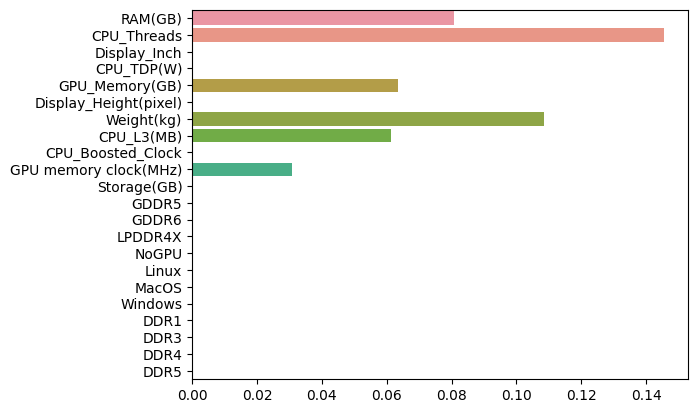

In [175]:
sns.barplot(y = X_train.columns, x = lasso.coef_, orient = 'h')

In [176]:
pickle.dump(lasso, open('lassomodel.pkl','wb'))

In [177]:
lassomodel = pickle.load(open('lassomodel.pkl','rb'))
print(lassomodel.predict([input])) 

[5.52429145]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


## Random Forest

In [178]:
max_n_estimators = 100
best_n_estimators = None
best_error = float('inf')
best_estimator = None
errors = []
for n_estimators in range(1, max_n_estimators):
    estimator = RandomForestRegressor(n_estimators = n_estimators)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    errors.append(error)
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_n_estimators = n_estimators

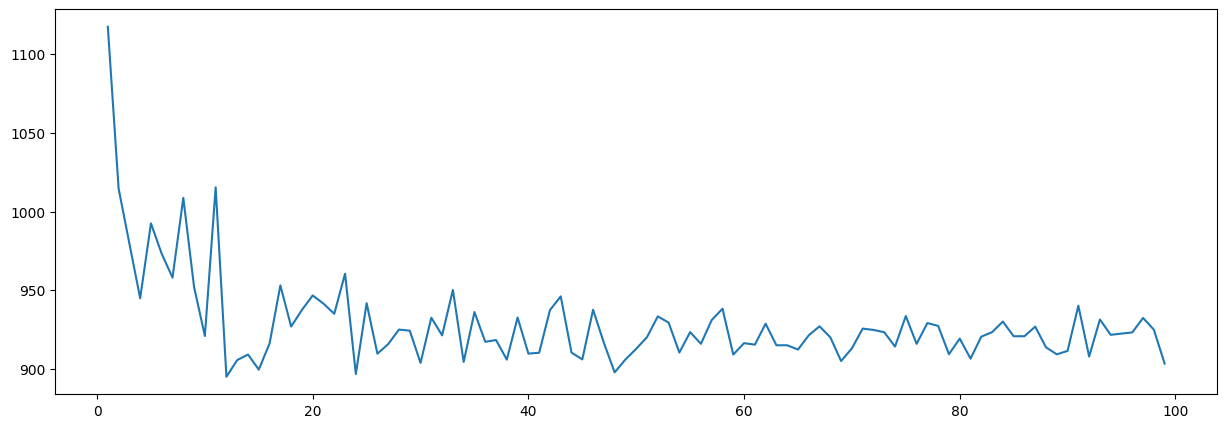

In [179]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, max_n_estimators), errors)

In [180]:
print("best parameter: ",best_n_estimators)
print("rmse: ", best_error)

best parameter:  12
rmse:  894.9840899395381


In [181]:
forest_reg = RandomForestRegressor(n_estimators = best_n_estimators)
forest_reg.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

RandomForestRegressor(n_estimators=12)

Text(0.5, 0, '%')

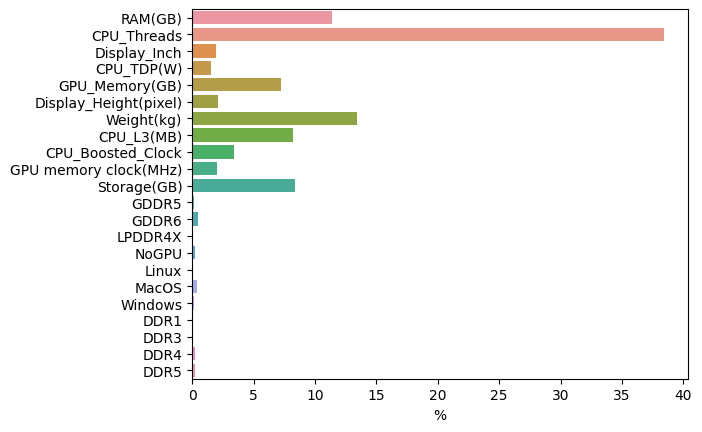

In [182]:
sns.barplot(y = X_train.columns, x = forest_reg.feature_importances_ * 100, orient = 'h')
plt.xlabel('%')

In [183]:
pickle.dump(forest_reg, open('forestmodel.pkl','wb'))

In [184]:
forestmodel = pickle.load(open('forestmodel.pkl','rb'))
print(forestmodel.predict([input]))

[5.91106539]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Extreme Gradient Boosting

In [185]:
max_n_estimators = 100
best_n_estimators = None
best_error = float('inf')
best_estimator = None
errors = []
for n_estimators in range(1, max_n_estimators):
    estimator = xgb.XGBRegressor(n_estimators = n_estimators)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    errors.append(error)
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_n_estimators = n_estimators

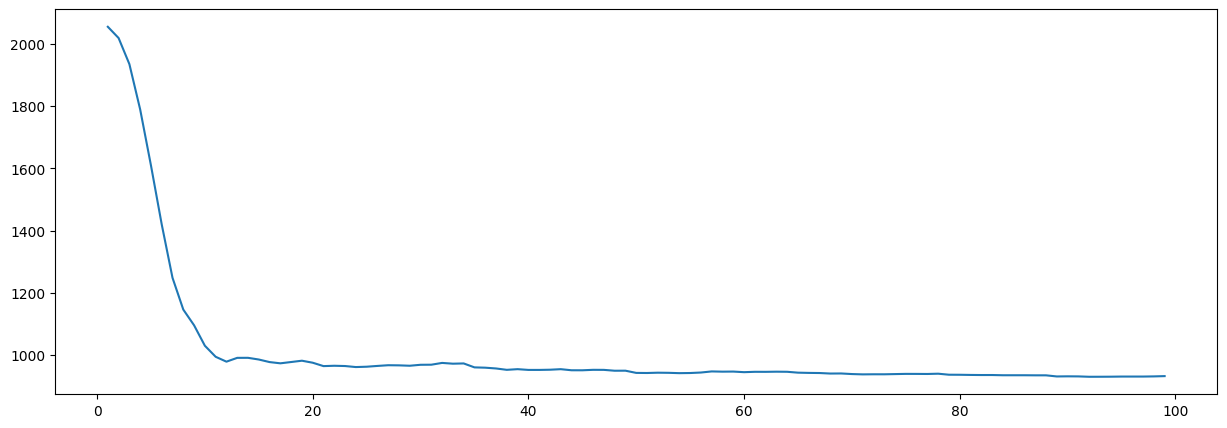

In [186]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, max_n_estimators), errors) 

In [187]:
print("best parameter: ",best_n_estimators)
print("rmse: ", best_error)

best parameter:  92
rmse:  929.8850139452576


In [188]:
xgb_reg = xgb.XGBRegressor(n_estimators = best_n_estimators)
xgb_reg.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=92, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Text(0.5, 0, '%')

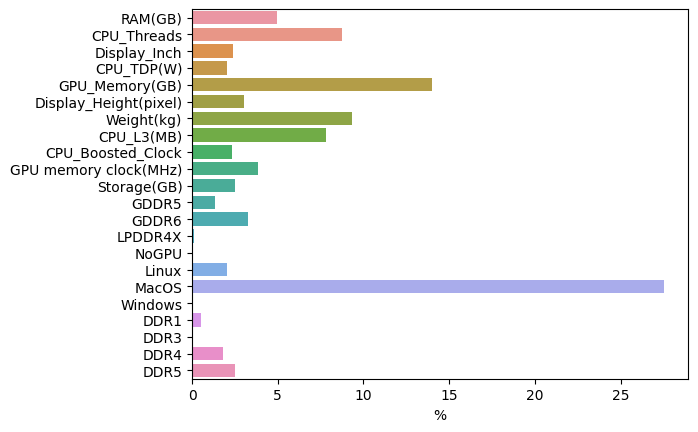

In [189]:
sns.barplot(y = X_train.columns, x = xgb_reg.feature_importances_ * 100, orient = 'h')
plt.xlabel('%')

In [190]:
pickle.dump(xgb_reg, open('xgbmodel.pkl','wb'))

In [191]:
xgbmodel = pickle.load(open('xgbmodel.pkl','rb'))
print(xgbmodel.predict([input])) 


ValueError: training data did not have the following fields: RAM(GB), CPU_Threads, Display_Inch, CPU_TDP(W), GPU_Memory(GB), Display_Height(pixel), Weight(kg), CPU_L3(MB), CPU_Boosted_Clock, GPU memory clock(MHz), Storage(GB), GDDR5, GDDR6, LPDDR4X, NoGPU, Linux, MacOS, Windows, DDR1, DDR3, DDR4, DDR5

## Final results

In [ ]:
data_test = pd.read_csv("./train_val_test/test.csv", index_col = 'Unnamed: 0')

In [ ]:
data_test.drop(['Year', 'CPU_Default_Clock', 'CPU_Transistor_Size(nm)', 'GPU clock(MHz)',
           'RAM_bus', 'CPU_Cores', 'GPU_Bus_Width(bit)', 'Display_Width(pixel)', 'Brand', 'CPU', 'GPU', 'Laptop_name'],
           axis = 1, inplace = True)
y_test = data_test['Price(USD)']
X_test = data_test.drop('Price(USD)', axis = 1)

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared = pd.DataFrame(X_test_prepared, index = y_test.index, columns = num_attribs + ['GDDR5','GDDR6','LPDDR4X','NoGPU'] + ['Linux', 'MacOS', 'Windows'] + ['DDR1','DDR3','DDR4','DDR5'])

In [ ]:
np.sqrt(mean_squared_error(np.exp(ridge.predict(X_test_prepared)), y_test))

770.9697339902033

In [ ]:
np.sqrt(mean_squared_error(np.exp(lasso.predict(X_test_prepared)), y_test))

720.3087715137679

In [ ]:
np.sqrt(mean_squared_error(np.exp(forest_reg.predict(X_test_prepared)), y_test))

320.6439732675772

In [ ]:
np.sqrt(mean_squared_error(np.exp(xgb_reg.predict(X_test_prepared)), y_test))

457.35564241124786

In [ ]:
#268.53319152105996